# Решающие деревья

Цель этого ноутбука &mdash; знакомство с решающими деревьями, с их параметрами и свойствами. В ноутбуке рассмотрены примеры применения решающих деревьев для решения задач классификации и регрессии.

In [1]:
from sklearn import datasets
from sklearn.metrics import accuracy_score, r2_score
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV

import numpy as np
from matplotlib.colors import ListedColormap
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(font_scale=1.5)

## Классификация с использованием решающего дерева

Для начала рассмотрим задачу классификации на простом датасете, состоящем только из двух признаков. Это сделает удобным процесс визуализации решающего дерева. Для генерации такого простого датасета воспользуемся методом `make_classification` модуля `sklearn.datasets`.

### Генерация данных

In [2]:
classification_problem = datasets.make_classification(
    n_features=2, n_informative=2, n_classes=3, n_redundant=0,
    n_clusters_per_class=1, random_state=3
)

Сопоставим каждому классу цвет

In [3]:
colors = ListedColormap(['#FF3300', '#0099CC', '#00CC66'])
light_colors = ListedColormap(['lightcoral', 'lightblue', 'lightgreen'])

In [4]:
data, target = classification_problem

In [5]:
print('dataset shape:', data.shape)
print('target shape:', target.shape)

dataset shape: (100, 2)
target shape: (100,)


Посмотрим на данные.

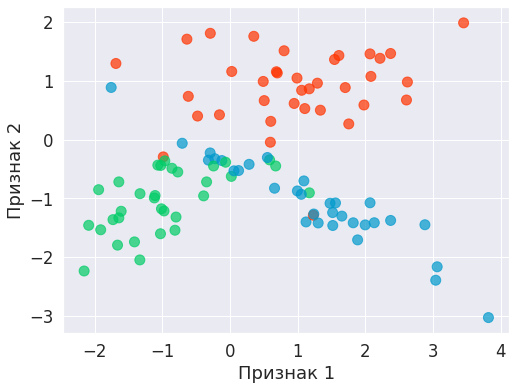

In [6]:
plt.figure(figsize=(8, 6))
grid_x1 = data[:, 0]
grid_x2 = data[:, 1]
plt.scatter(grid_x1, grid_x2, c=target, cmap=colors, s=100, alpha=0.7)
plt.xlabel('Признак 1'), plt.ylabel('Признак 2');

Разобьём данные на обучающую и тестовую выборки.

In [7]:
X_train, X_test, y_train, y_test = train_test_split(
    data, target, test_size=0.3, random_state=777
)

Инициализируем и обучим решающее дерево для классификации.

In [8]:
clf = DecisionTreeClassifier(random_state=42)
clf.fit(X_train, y_train)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
                       max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort=False,
                       random_state=42, splitter='best')

In [9]:
predictions = clf.predict(X_test)
print('test accuracy:', accuracy_score(predictions, y_test))

test accuracy: 0.9


Неплохой результат. Но на таком простом датасете могло быть и лучше.

### Визуализация решающей поверхности (decision surface)

При использовании решающего дерева в простых задачах (когда в данных один или два признака) бывает полезно посмотреть на разделяющую поверхность. По виду разделяющей поверхности можно получить представление, действительно ли дерево улавливает важные закономерности в данных и не возникло ли переобучения. Если данные имеют большое число признаков, то визуализировать разделяющую поверхность довольно сложно. Но в нашем случае (в данных ровно два признака) всё достаточно просто.

In [10]:
def get_meshgrid(data, step=.05, border=.5,):
    '''
    Функция для получения сетки точек (x1, x2) 
    для дальнейшего отображения их на графиках
    
    Параметры:
    1) data - входной датасет, набор точек (x1_i, x2_i);
    2) step - мелкость сетки;
    3) border - отступ от минимальных и максимальных значений x1, x2 в data 
    в сетке
    '''
    
    x1_min, x1_max = data[:, 0].min() - border, data[:, 0].max() + border
    x2_min, x2_max = data[:, 1].min() - border, data[:, 1].max() + border
    return np.meshgrid(np.arange(x1_min, x1_max, step), 
                       np.arange(x2_min, x2_max, step))

In [11]:
def plot_decision_surface(
    estimator, X_train, y_train, X_test, y_test, colors=colors, 
    light_colors=light_colors, title='',metric=accuracy_score
):
    '''
    Функция для отображения разделяющей поверхности классификатора
    
    Параметры:
    1) estimator - классификатор;
    2) X_train, y_train - данные и разметка обучающей выборки;
    3) X_test, y_test - данные и разметка тестовой выборки;
    4) colors - цвета для отображения точек из разных классов;
    5) light_colors - цветовая схема для отображения разделяющей поверхности;
    6) title - заголовок графика.
    '''
    
    # обучаем модель
    estimator.fit(X_train, y_train)
    
    plt.figure(figsize=(16, 6))
    
    # отображаем разделяющую поверхность и точки обучающей выборки
    plt.subplot(1,2,1)
    x1_values, x2_values = get_meshgrid(X_train)
    x1_ravel, x2_ravel = x1_values.ravel(), x2_values.ravel()
    mesh_predictions_ravel = estimator.predict(np.c_[x1_ravel, x2_ravel])
    mesh_predictions = np.array(mesh_predictions_ravel).reshape(x1_values.shape)
    
    plt.pcolormesh(x1_values, x2_values, mesh_predictions, cmap=light_colors)
    plt.scatter(X_train[:, 0], X_train[:, 1], c=y_train, 
                s=100, cmap=colors, edgecolors='black')
    plt.xlabel('Признак 1'), plt.ylabel('Признак 2')
    plt.title('Train data, {}={:.2f}'.format(
        metric.__name__,metric(y_train, estimator.predict(X_train))
    ))
    
    # отображаем разделяющую поверхность и точки тестовой выборки
    plt.subplot(1,2,2)
    plt.pcolormesh(x1_values, x2_values, mesh_predictions, cmap=light_colors)
    plt.scatter(X_test[:, 0], X_test[:, 1], c=y_test, 
                s=100, cmap=colors, edgecolors='black')
    plt.title('Test data, {}={:.2f}'.format(
        metric.__name__, metric(y_test, estimator.predict(X_test))
    ))
    plt.xlabel('Признак 1'), plt.ylabel('Признак 2')
    plt.suptitle(title, fontsize=20)

### Визуализация разделяющей поверхности при изменении параметра `max_depth`

Посмотрим, как будет меняться разделяющая поверхность при изменении значения параметра `max_depth`.

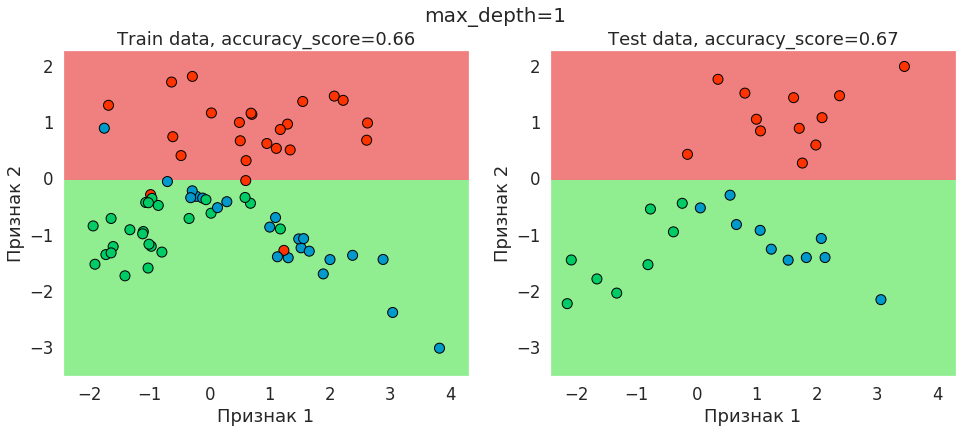

In [12]:
estimator = DecisionTreeClassifier(random_state=42, max_depth=1)
plot_decision_surface(estimator, X_train, y_train, 
                      X_test, y_test, title='max_depth=1')

Разделяющая поверхность оказалась довольно простой. Ведь если глубина дерева равна одному, то в нём происходит разделение выборки ровно по одному признаку. Несложно заметить, что если в датасете для классификации $k$ классов, то необходимо брать дерево с глубиной не менее $\log_2 k$, так как мы хотим, чтобы в полученном дереве было не менее $k$ листьев (иначе дерево будет предсказывать $< k$ классов, чего мы хотим избежать).
Попробуем увеличить максимальную глубину дерева.

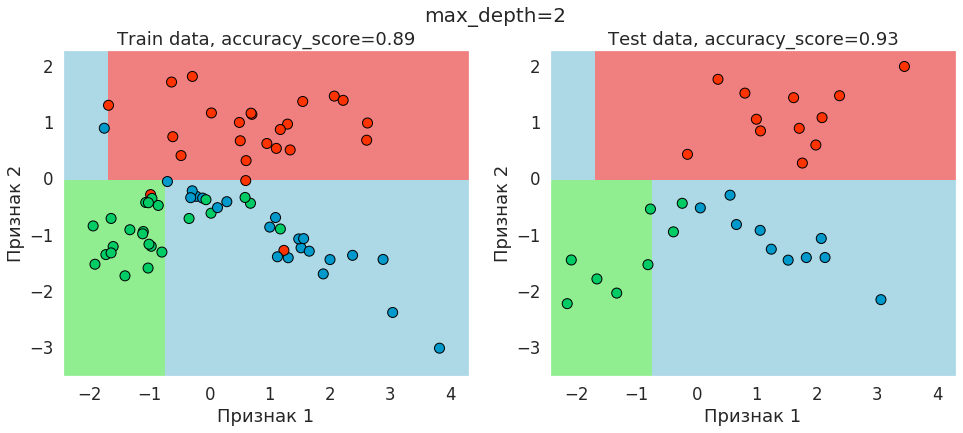

In [13]:
estimator = DecisionTreeClassifier(random_state=42, max_depth=2)
plot_decision_surface(estimator, X_train, y_train, 
                      X_test, y_test, title='max_depth=2')

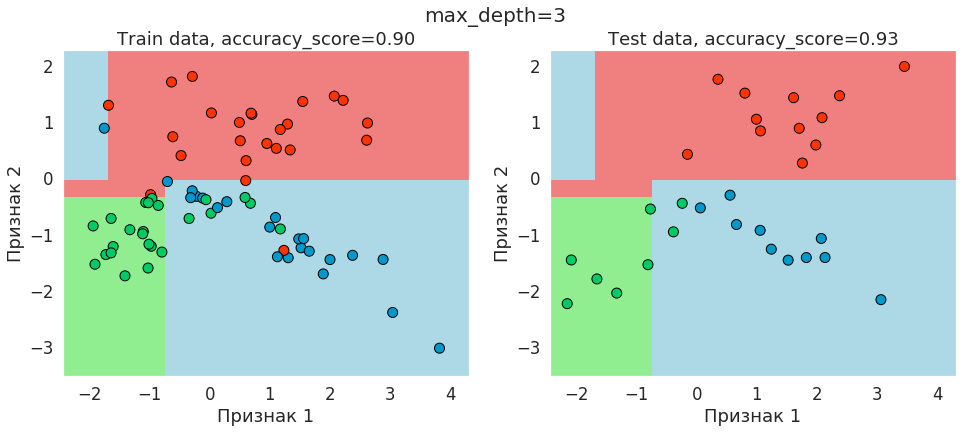

In [14]:
estimator = DecisionTreeClassifier(random_state=42, max_depth=3)
plot_decision_surface(estimator, X_train, y_train, 
                      X_test, y_test, title='max_depth=3')

Заметим, что сложность разделяющей поверхности заметно увеличилась. Точность предсказания дерева заметно возросла. 

А теперь посмотрим, что произойдёт, если резко увеличить значение параметра `max_depth`.

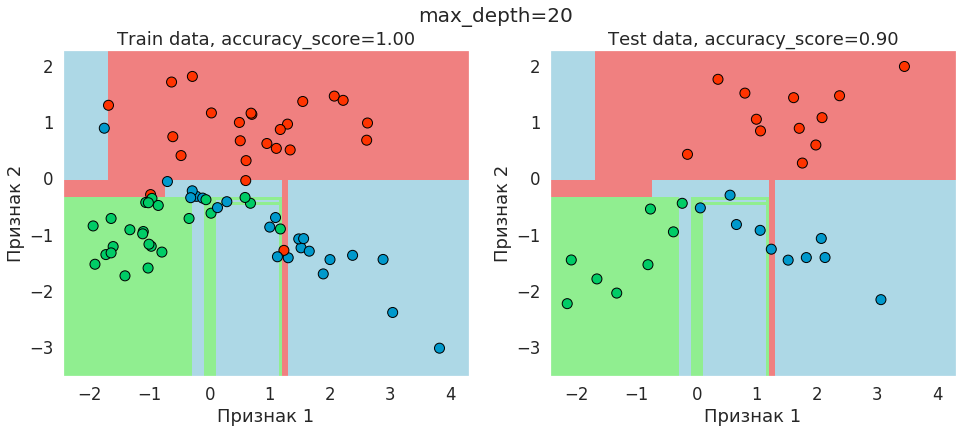

In [15]:
estimator = DecisionTreeClassifier(random_state=42, max_depth=20)
plot_decision_surface(estimator, X_train, y_train, 
                      X_test, y_test, title='max_depth=20')


Заметим, что accuracy на обучающей выборке стало равно единице, а на тестовой выборке стало хуже, чем при максимальной возможной глубине, равной трем. Это означает, что произошло **переобучение дерева**. Этот пример демонстрирует проявление на практике следующих свойств решающих деревьев:

1. Решающие деревья очень легко могут быть переобучены, причём склонность к переобучению возрастает с возрастанием глубины дерева.
2. Для любой выборки для классификации существует решающее дерево, идеально восстанавливающее истинный отклик.

**Вывод.**

Как правило, увеличение значения параметра `max_depth` приводит к увеличению точности классификации на обучающей выборке, но с некоторого момента увеличение значения `max_depth` приводит к ухудшению точности на тестовой выборке, так как начинается стадия переобучения.

### Визуализация разделяющей поверхности при изменении параметра `min_samples_leaf`

Другим важным параметром решающего дерева является `min_samples_leaf` &mdash; минимальное количество элементов выборки, которые могут находиться в листовой вершине дерева. При разбиении вершины дерева проверяется, что после разбиения количество элементов выборки, находящихся как в левой, так и в правой дочерних вершинах не меньше `min_samples_leaf`. Если это условие не выполняется, то такое разбиение отвергается.

Такое условие необходимо для того, чтобы предсказание для данного листа было достаточно устойчиво. Например, если попал только один объект, то предсказание для данного листа будет равно таргету данного объекта, что является достаточно шумным предсказанием, а если попало 5 объектов, то предсказание будет более устойчиво к шуму и выбросам. Кроме того, без ограничения возможна ситуация, при которой один объект может определить метку для большой области в пространстве, находясь при этом на границе этой области.

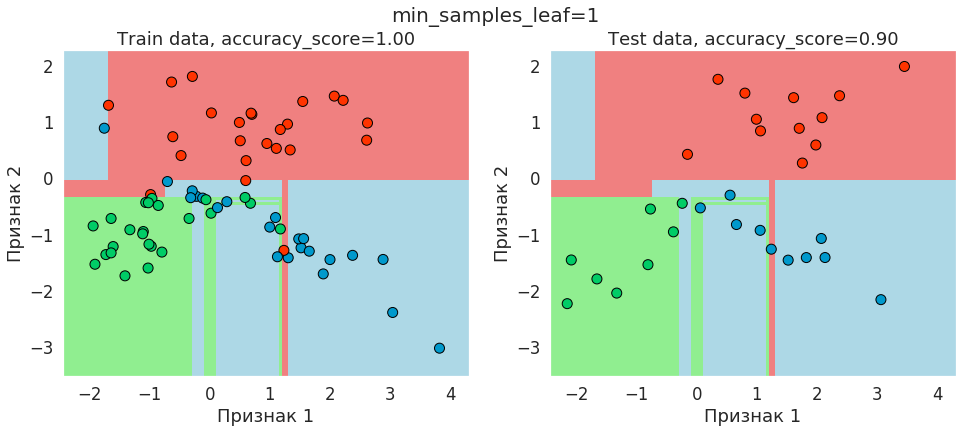

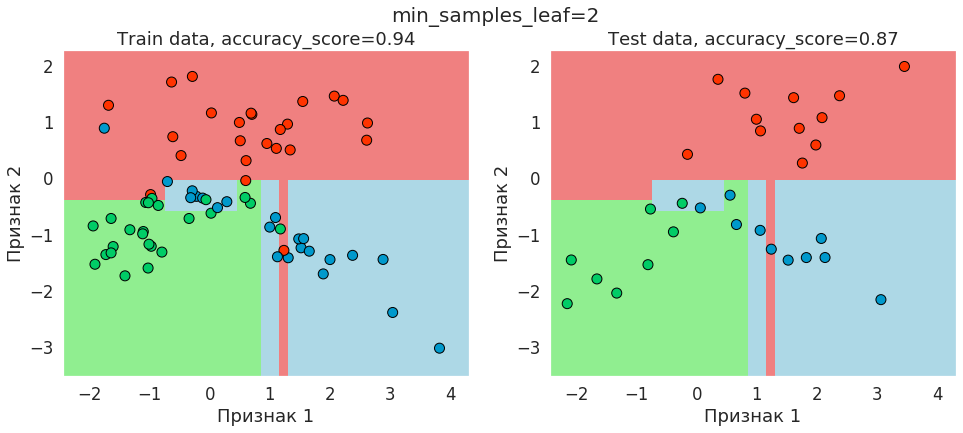

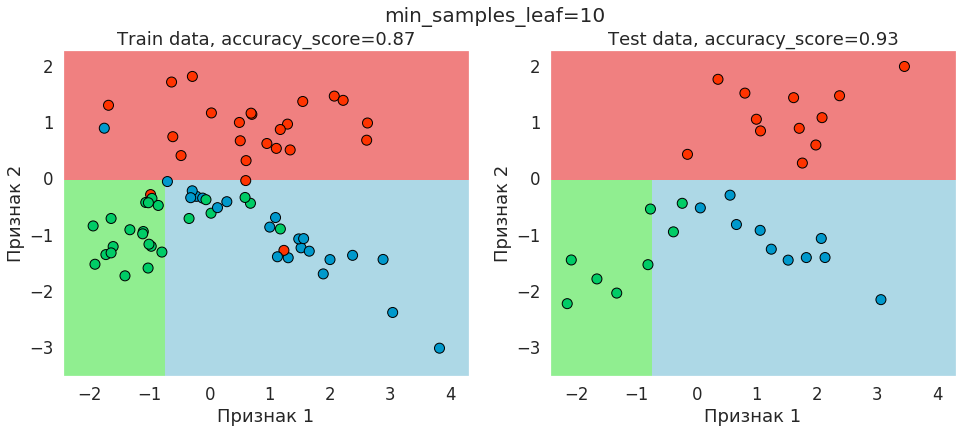

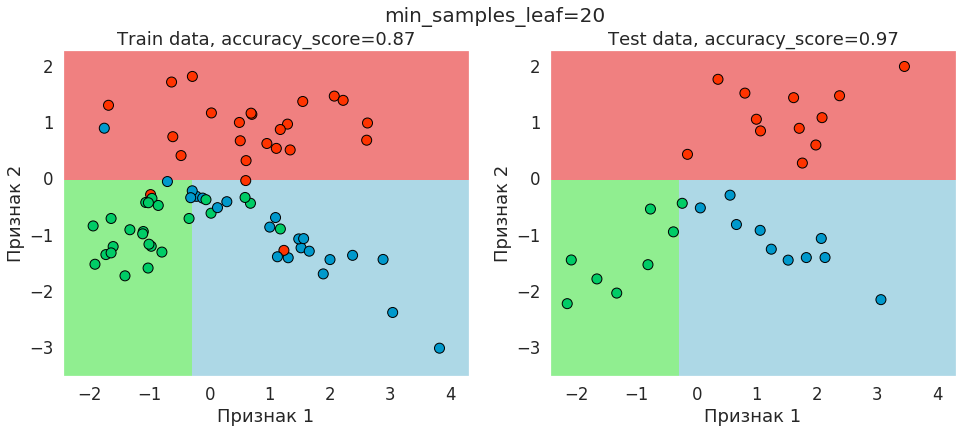

In [16]:
for min_samples_leaf in [1, 2, 10, 20]:
    estimator = DecisionTreeClassifier(random_state=42, 
                                       min_samples_leaf=min_samples_leaf)
    plot_decision_surface(
        estimator, X_train, y_train, X_test, y_test, 
        title=f'min_samples_leaf={min_samples_leaf}'
    )

Построим график зависимости accuracy от `min_samples_leaf` на обучающей и на тестовой выборках.

In [17]:
def get_train_and_test_accuracy(param_name, grid):
    '''
    Функция для оценки точности классификации 
    для заданных значений параметра param_name
    
    Параметры:
    1) param_name - название параметра, который собираемся варьировать,
    2) grid - сетка значений параметра
    '''
        
    train_acc, test_acc = [], []
    
    for param_value in grid:
        estimator = DecisionTreeClassifier(**{param_name: param_value})
        estimator.fit(X_train, y_train)
        train_acc.append(accuracy_score(y_train, estimator.predict(X_train)))
        test_acc.append(accuracy_score(y_test, estimator.predict(X_test)))
    return train_acc, test_acc

In [18]:
def plot_dependence(param_name, grid=range(2, 20), title=''):
    '''
    Функция для отображения графика зависимости accuracy 
    от значения параметра c названием param_name
    
    Параметры:
    1) param_name - название параметра, который собираемся варьировать,
    2) grid - сетка значений параметра,
    3) title - заголовок графика
    '''
    
    plt.figure(figsize=(12, 6))
    
    train_acc, test_acc = get_train_and_test_accuracy(param_name, grid)
        
    plt.plot(grid, train_acc, label='train', lw=3)
    plt.plot(grid, test_acc, label='test', lw=3)
    plt.legend(fontsize=14)
    plt.xlabel(param_name)
    plt.ylabel('Аccuracy')
    plt.title(title, fontsize=20)
    plt.show()

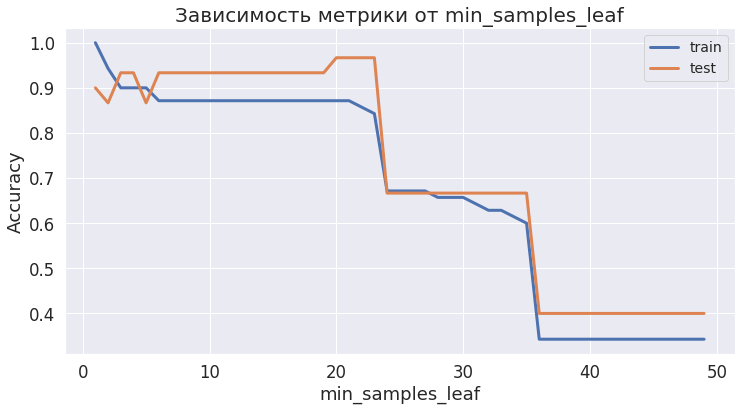

In [19]:
plot_dependence('min_samples_leaf', range(1, 50), 
                title='Зависимость метрики от min_samples_leaf')

**Вывод.**

В целом наблюдается следующая закономерность: с увеличением значения `min_samples_leaf` качество на обучающей выборке падает, а на тестовой выборке сначала возрастает, а затем начинает убывать. Получается, увеличение значения параметра `min_samples_leaf` &mdash; один из способов борьбы с переобучением при использовании решающих деревьев.

Но, всё же, стоит заметить, что повышение значения `min_samples_leaf` делает разделяющую поверхность проще. Значит, при слишком больших значениях `min_samples_leaf` модель становится слишком простой и перестаёт улавливать закономерности из данных.

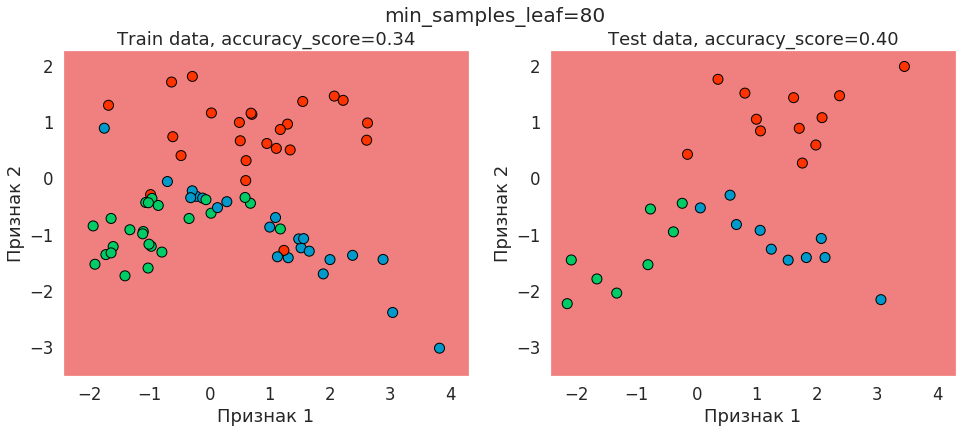

In [20]:
estimator = DecisionTreeClassifier(random_state=42, 
                                   min_samples_leaf=80)
plot_decision_surface(estimator, X_train, y_train, 
                      X_test, y_test, title='min_samples_leaf=80')

Здесь мы привели пример решающего дерева при использовании `min_samples_leaf=80`.

### Визуализация разделяющей поверхности при изменении параметра `min_samples_split`

Последний параметр, который мы будем подробно визуализировать &mdash; `min_samples_split`, минимальное количество элементов, которое должно попасть в вершину, чтобы её можно было делить. 

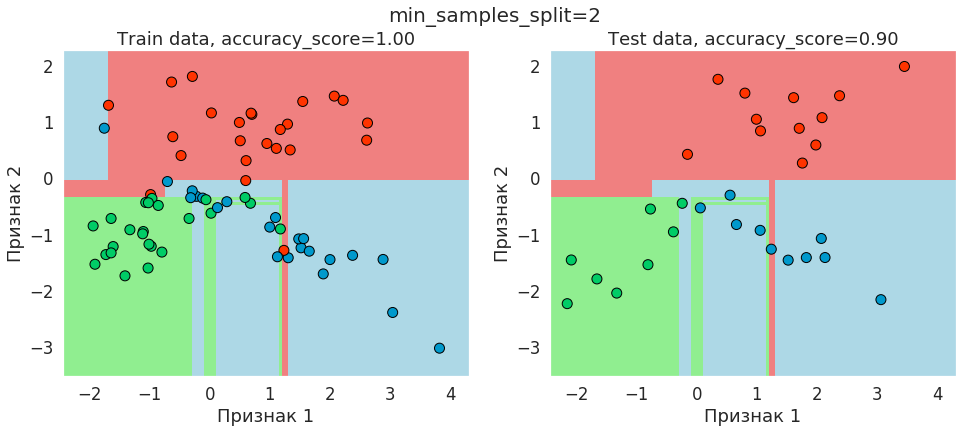

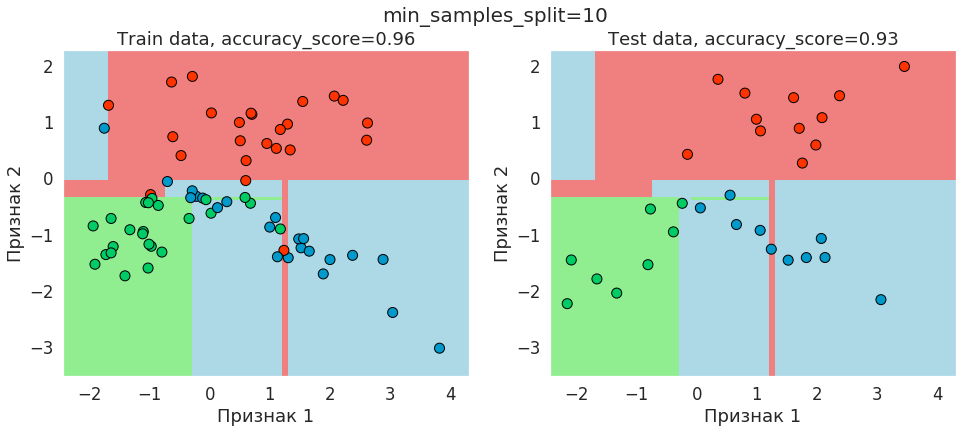

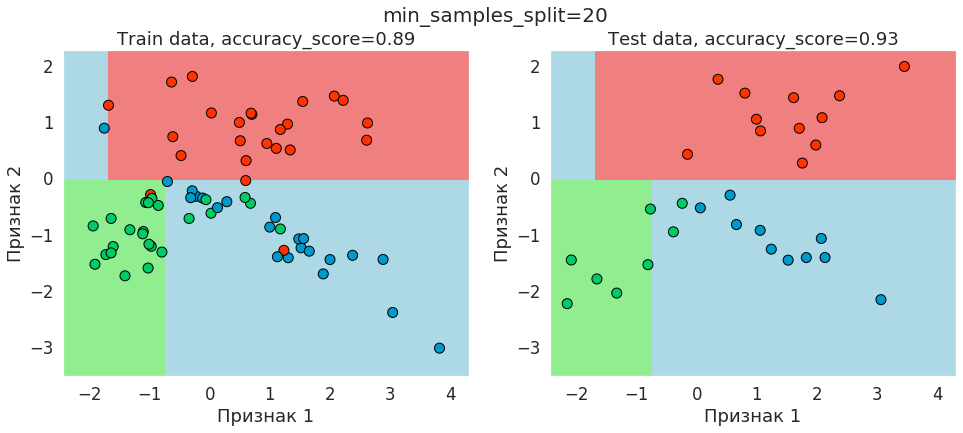

In [21]:
for min_samples_split in [2, 10, 20]:
    estimator = DecisionTreeClassifier(
        random_state=42, min_samples_leaf=1,
        min_samples_split=min_samples_split
    )
    plot_decision_surface(
        estimator, X_train, y_train, X_test, y_test, 
        title=f'min_samples_split={min_samples_split}'
    )

А теперь попробуем резко увеличить значение `min_samples_split`.

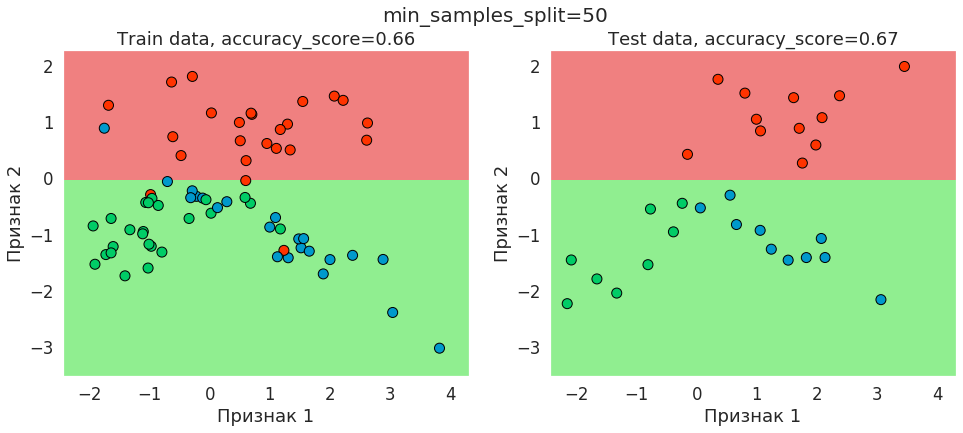

In [22]:
estimator = DecisionTreeClassifier(
    random_state=42, min_samples_leaf=1, min_samples_split=50
)
plot_decision_surface(estimator, X_train, y_train, 
                      X_test, y_test, title='min_samples_split=50')

**Вывод.**

При изменении значения `min_samples_split` происходит ситуация, аналогичной случаю, когда мы варьируем `min_samples_leaf`. И здесь наблюдается следующая закономерность: с увеличением значения `min_samples_split` качество на обучающей выборке падает, а на тестовой выборке &mdash; до некоторого момента возрастает. Кроме того, с увеличением `min_samples_split` разделяющая поверхность становится проще.

### Датасет `iris`

А теперь обучим решающее дерево на датасете `iris` для классификации ирисов на три вида. В этом датасете каждый цветок представлен вещественнозначным вектором размера 4.

In [23]:
iris = datasets.load_iris()
X = iris.data
y = iris.target
print('dataset shape:', X.shape)
print('target shape:', y.shape)

dataset shape: (150, 4)
target shape: (150,)


Разобьём данные на обучающую и тестовую выборки.

In [24]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

Зададим сетку для подбора параметров и сделаем кросс-валидацию с 5 фолдами (значение по умолчанию).

In [25]:
tree_gridsearch = GridSearchCV(
    estimator=DecisionTreeClassifier(),
    param_grid={'max_depth': np.arange(2, 7), 
                'min_samples_leaf': [1, 2, 5, 10]}
)

In [26]:
tree_gridsearch.fit(X_train, y_train)

/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


GridSearchCV(cv='warn', error_score='raise-deprecating',
             estimator=DecisionTreeClassifier(class_weight=None,
                                              criterion='gini', max_depth=None,
                                              max_features=None,
                                              max_leaf_nodes=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              presort=False, random_state=None,
                                              splitter='best'),
             iid='warn', n_jobs=None,
             param_grid={'max_depth': array([2, 3, 4, 5, 6]),
                         'min_samples_leaf': [1, 2, 5, 10]},
        

Выведем оптимальные параметры.

In [27]:
print(tree_gridsearch.best_params_)

{'max_depth': 3, 'min_samples_leaf': 5}


In [28]:
print('train accuracy:', accuracy_score(
    tree_gridsearch.best_estimator_.predict(X_train), y_train
))
print('test accuracy:', accuracy_score(
    tree_gridsearch.best_estimator_.predict(X_test), y_test
))

train accuracy: 0.9464285714285714
test accuracy: 1.0


Получилось довольно неплохое качество предсказания. На тестовой выборке метки совпали с истинными значениями.

Теперь посмотрим, как accuracy на обучающей и тестовой выборке зависит от выбранного значения `min_samples_leaf`.

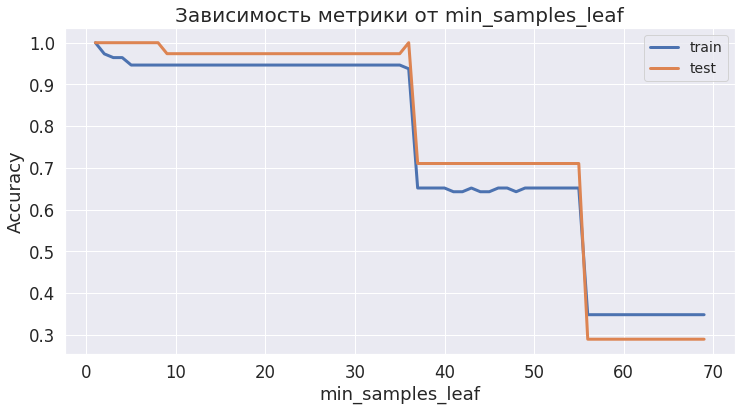

In [29]:
plot_dependence(
    'min_samples_leaf', range(1, 70),
    title='Зависимость метрики от min_samples_leaf'
)

**Вывод.**

По графику видно, что обобщающая способность решающего дерева начинает падать при `min_samples_leaf > 6`.

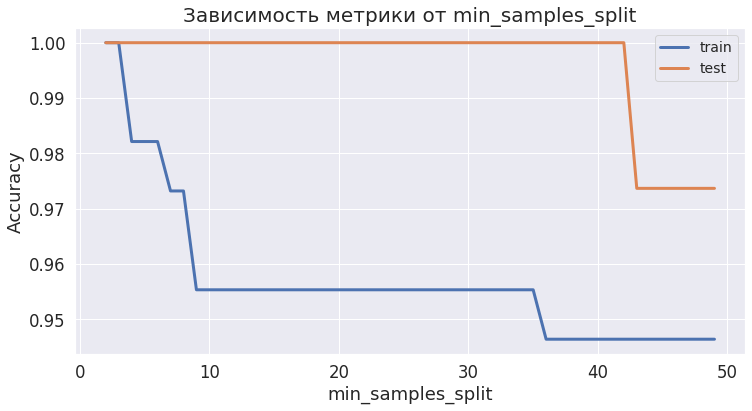

In [30]:
plot_dependence(
    'min_samples_split', grid=range(2, 50), 
    title='Зависимость метрики от min_samples_split'
)

**Вывод.**

Значение accuracy на `train` монотонно падает с ростом `mean_samples_split`, а значение accuracy на `test` стабилизируется до некоторого момента.

#### Другие параметры.

Кроме того, обратите внимание на другие параметры класса `DecisionTreeClassifier` в `sklearn`:

1) `criterion` &mdash; критерий, по которому происходит разбиение вершины дерева. Стандартные критерии для классификации &mdash; критерий Джини (`giny`) и энтропийный критерий (`entropy`), при этом `giny` &mdash; критерий по умолчанию.  В этом ноутбуке мы брали для классификации критерий по умолчанию.  Более подробную информацию по критериям можно найти в <a href="https://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeClassifier.html">документации sklearn</a>.


2) `splitter` &mdash; способ разбиения вершины решающего дерева. Есть два возможных варианта: `best` и `random`. В первом случае рассматриваются все возможные способы разбить вершину дерева на две и берётся тот из них, значение критерия для которого оптимально. При `splitter=random` берётся несколько случайных возможных разбиений и среди них выбирается то, значение критерия для которого оптимально.

3) `max_features` &mdash; максимальное количество признаков, которые могут быть перебраны при разбиении вершины дерева. Перед каждым разбиением вершины генерируется выборка из `min(k, max_features)` случайных признаков (`k` &mdash; количество признаков в датасете) и только эти признаки рассматриваются как разделяющие.

4) `min_impurity_split` &mdash; минимальное значение критерия неопределенности (`impurity`) для выборки, попавшей в вершину, чтобы эту выборку можно было разбивать.

Об остальных гиперпараметрах класса решающего дерева в `sklearn` можно прочитать в документации.

## Регрессия с использованием решающего дерева

В регрессии будем использовать все те же параметры разбиения. Но в качестве критерия неопределенности (параметр `criterion`) используются `mse`, `friedman_mse`, `mae`, причём `mse` &mdash; критерий по умолчанию..


Сгенерируем регрессионные данные.

In [31]:
classification_problem = datasets.make_regression(
    n_features=2, n_informative=2, random_state=3, n_samples=200
)
data, target = classification_problem

Визуализируем. Отклик показан цветом точки.

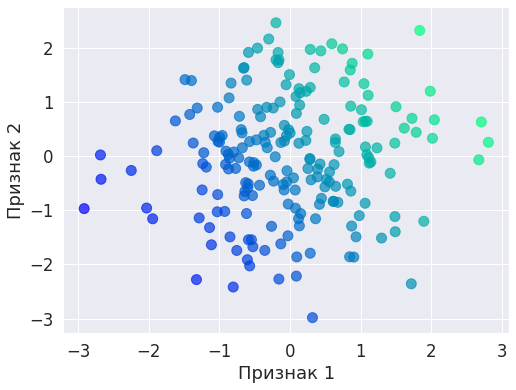

In [32]:
plt.figure(figsize=(8, 6))
grid_x1 = data[:, 0]
grid_x2 = data[:, 1]
plt.scatter(grid_x1, grid_x2, c=target, s=100, alpha=0.7, cmap='winter')
plt.xlabel('Признак 1'), plt.ylabel('Признак 2');

Разобьём данные на обучение и тест.

In [33]:
X_train, X_test, y_train, y_test = train_test_split(data, target, 
                                                    random_state=42)

Исследуем зависимость качества работы регрессионного дерева в зависимости от максимально возможной его глубины.  

Цветом поверхности обозначается ответ в листе. Но для регрессит это не класс, а некоторое число.

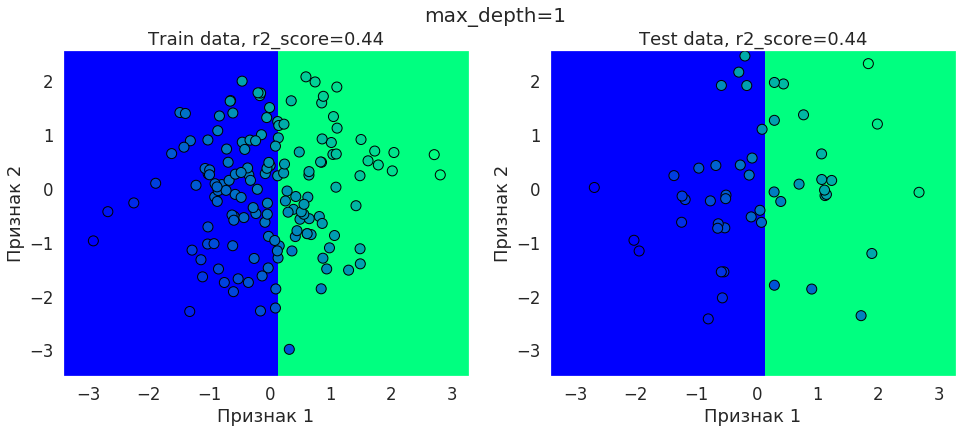

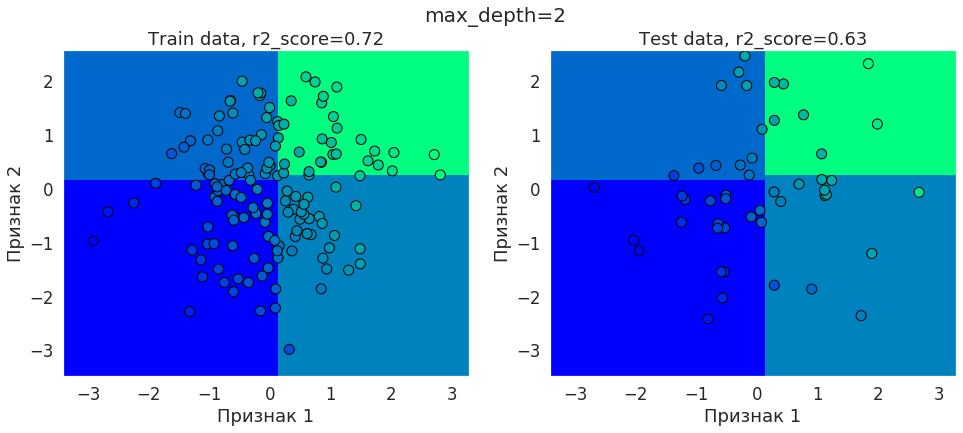

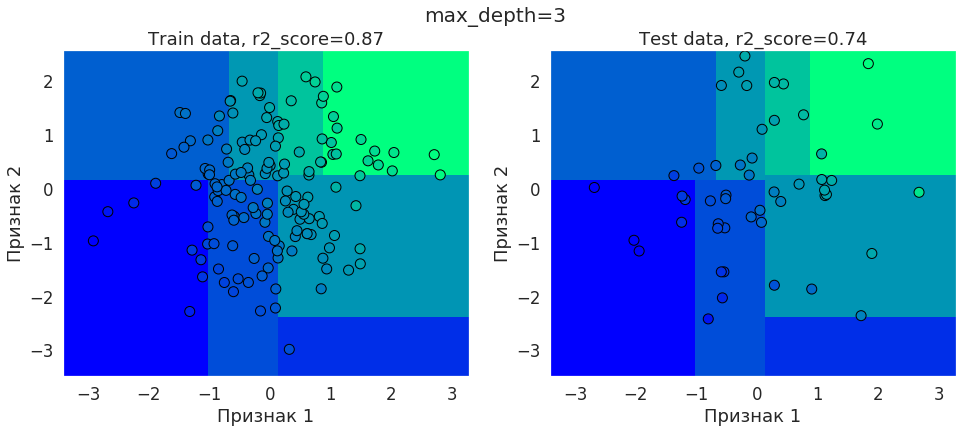

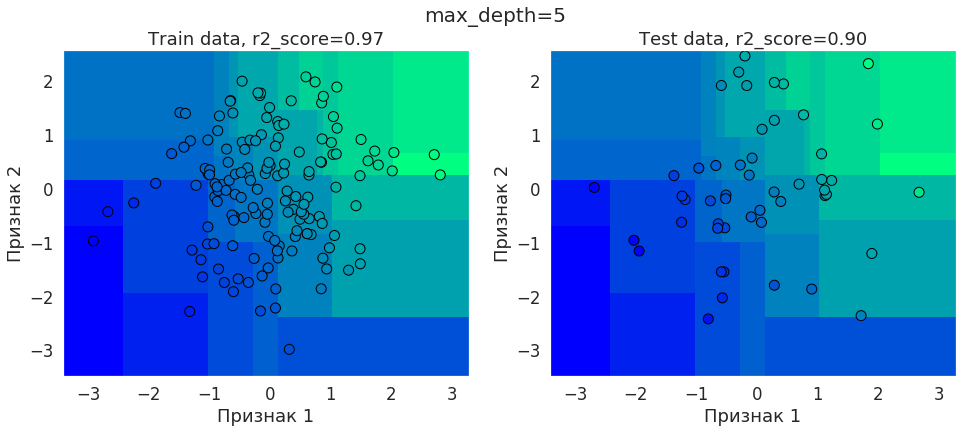

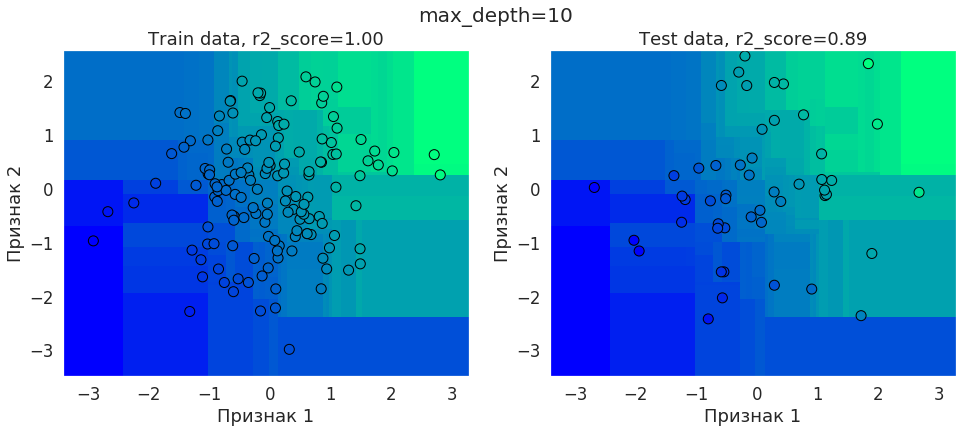

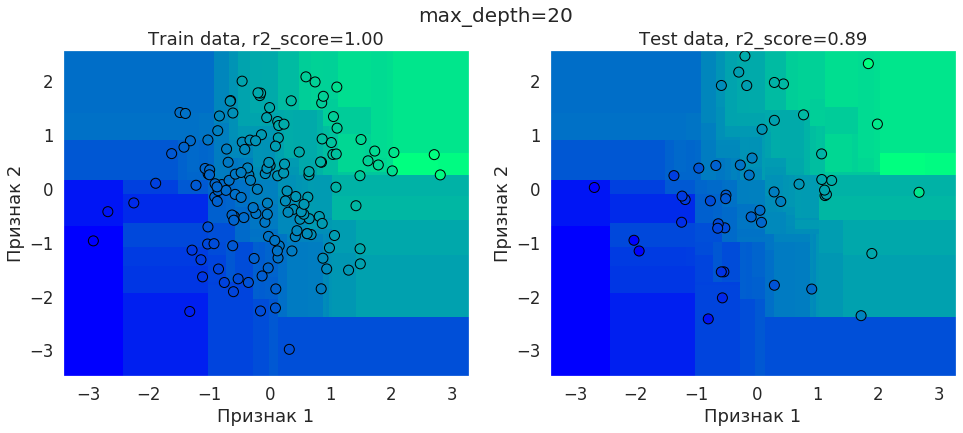

In [34]:
for max_depth in [1, 2, 3, 5, 10, 20]:
    estimator = DecisionTreeRegressor(random_state=42, max_depth=max_depth)
    plot_decision_surface(estimator, X_train, y_train, X_test, y_test, 
                          title='max_depth={}'.format(max_depth), colors='winter',
                          light_colors='winter', metric=r2_score)

Для решения задачи регрессии недостаточно малой глубины дерева, но как в задаче классификации при слишком большой глубине может происходить переобучение. Регрессионная зависимость, восстанавливаемая деревом, выглядит сильно сложно.

### Датасет `diabetes`

В качестве данных возьмём датасет `diabetes` из `sklearn`. В нём исследуется численная оценка прогрессирования диабета у пациентов на основе таких признаков, как возраст, пол, масса тела, среднее кровяное давление и некоторых других. Для того, чтобы лучше понять, что из себя представляют признаки в этом датасете, можно обратиться к этой странице: https://www4.stat.ncsu.edu/~boos/var.select/diabetes.html.

In [35]:
diabetes = datasets.load_diabetes() 
X = diabetes.data
y = diabetes.target

In [36]:
print('data shape:', X.shape)
print('target shape:', y.shape)

data shape: (442, 10)
target shape: (442,)


Как и в предыдущих экспериментах, разобьём данные на обучение и тест.

In [37]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

Подберём оптимальные параметры для `DecisionTreeRegressor` по сетке.

In [38]:
tree_gridsearch = GridSearchCV(
    estimator=DecisionTreeRegressor(random_state=42),
    param_grid={'max_depth': [5, 10, 15, 20, 30], 
                'min_samples_leaf': [1, 2, 5]}
)

In [39]:
tree_gridsearch.fit(X_train, y_train)

/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


GridSearchCV(cv='warn', error_score='raise-deprecating',
             estimator=DecisionTreeRegressor(criterion='mse', max_depth=None,
                                             max_features=None,
                                             max_leaf_nodes=None,
                                             min_impurity_decrease=0.0,
                                             min_impurity_split=None,
                                             min_samples_leaf=1,
                                             min_samples_split=2,
                                             min_weight_fraction_leaf=0.0,
                                             presort=False, random_state=42,
                                             splitter='best'),
             iid='warn', n_jobs=None,
             param_grid={'max_depth': [5, 10, 15, 20, 30],
                         'min_samples_leaf': [1, 2, 5]},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scor

In [40]:
print(tree_gridsearch.best_params_)

{'max_depth': 5, 'min_samples_leaf': 5}


Посчитаем значение метрики `r2-score` ($R^2$).

In [41]:
print('train r2_score {:.4f}'.format(r2_score(
    tree_gridsearch.best_estimator_.predict(X_train), y_train
)))
print('test r2_score {:.4f}'.format(r2_score(
    tree_gridsearch.best_estimator_.predict(X_test), y_test
)))

train r2_score 0.4972
test r2_score 0.1798


Теперь попробуем резко увеличить значение `max_depth`.

In [42]:
regressor = DecisionTreeRegressor(random_state=42, max_depth=50, 
                                  min_samples_leaf=5)
regressor.fit(X_train, y_train)

print('train r2_score {:.4f}'.format(r2_score(
    regressor.predict(X_train), y_train
)))
print('test r2_score {:.4f}'.format(r2_score(
    regressor.predict(X_test), y_test
)))

train r2_score 0.7220
test r2_score 0.1439


**Вывод.**

Видно, что значение $R^2$ на обучающей выборке выросле, а на валидационной упало. Значит, дерево переобучилось.

Теперь попробуем, наоборот, сделать значение `max_depth` меньше оптимального.

In [43]:
regressor = DecisionTreeRegressor(random_state=42, max_depth=3, 
                                  min_samples_leaf=5)
regressor.fit(X_train, y_train)

print('train r2_score {:.4f}'.format(r2_score(
    regressor.predict(X_train), y_train
)))
print('test r2_score {:.4f}'.format(r2_score(
    regressor.predict(X_test), y_test
)))

train r2_score 0.0347
test r2_score -0.2510


**Вывод.**

Заметим, что значение $R^2$ снизилось как на обучающей, так и на тестовой выборке. Это значит, что модель с такой глубиной недообучена и плохо улавливает закономерности в данных

### Бонусная часть

1. Рассмотрите те параметры решающих деревьев, которые не были подробно разобраны в этом ноутбуке и сделайте для них такой же визуальный анализ.

2. Возьмите один из датасетов для регрессии из `sklearn.datasets` на ваш выбор, подберите по сетке оптимальные параметры для решающего дерева и сравните результаты работы решающего дерева с результатами линейной регрессии с различными видами регуляризации.